<a href="https://colab.research.google.com/github/yogeshdhome/Coursera-IBM-AI-ML-Course/blob/master/Fake_News_Detection_using_LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

In [3]:
from sklearn.model_selection import train_test_split

In [4]:
fake = pd.read_csv('/content/sample_data/Fake.csv')
real = pd.read_csv('/content/sample_data/True.csv')

In [5]:
fake.columns

Index(['title', 'text', 'subject', 'date'], dtype='object')

In [6]:
fake.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23481 entries, 0 to 23480
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   title    23481 non-null  object
 1   text     23481 non-null  object
 2   subject  23481 non-null  object
 3   date     23481 non-null  object
dtypes: object(4)
memory usage: 733.9+ KB


In [7]:
real.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21417 entries, 0 to 21416
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   title    21417 non-null  object
 1   text     21417 non-null  object
 2   subject  21417 non-null  object
 3   date     21417 non-null  object
dtypes: object(4)
memory usage: 669.4+ KB


In [8]:
fake.sample(5)

,title,text,subject,date
18184,WATCH: ACTOR JAMES WOODS Shares HILARIOUS Vide...,This is a MUST WATCH and SHARE!If anyone s won...,left-news,"Aug 8, 2017"
18425,SARAH HUCKABEE-SANDERS Destroys Room Full Of F...,White House Deputy Press Secretary Sarah Hucka...,left-news,"Jun 27, 2017"
20580,POLICE CALLED TO GRISLY MURDER SCENE: Find Dec...,"Better a blow-up doll than an actual citizen, ...",left-news,"May 13, 2016"
11292,FAKE NEWS ALERT! FORMER GOV OF MARYLAND Calls ...,,politics,"Mar 26, 2017"
20779,WATCH: BLACK LIVES MATTER Bernie Sanders Suppo...,"The new Democrat party Godless Socialists, rac...",left-news,"Apr 4, 2016"


In [9]:
fake['subject'].value_counts()

News               9050
politics           6841
left-news          4459
Government News    1570
US_News             783
Middle-east         778
Name: subject, dtype: int64

In [10]:
real['subject'].value_counts()

politicsNews    11272
worldnews       10145
Name: subject, dtype: int64

In [11]:
len(fake['text'].max())

1150

In [12]:
len(real['text'].max())

3293

In [13]:
fake['class'] = 0
real['class'] = 1

WordCloud Map (Data Visualization)

In [14]:
from wordcloud import WordCloud

In [15]:
fake_text = ' '.join(list(fake['text']))
real_text = ' '.join(list(real['text']))

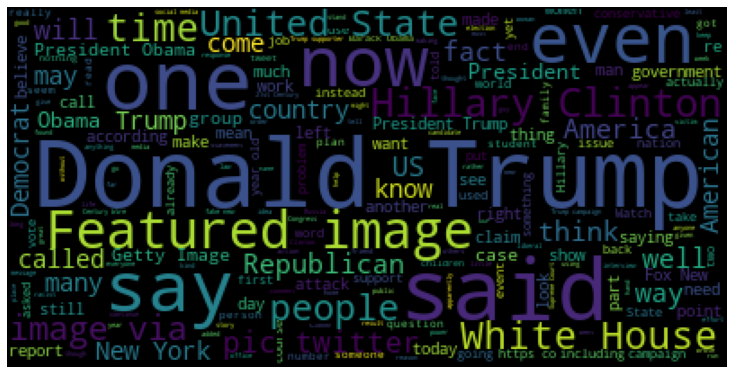

In [16]:
wordcloud = WordCloud()
plt.figure(figsize=(10,8))
plt.imshow(wordcloud.generate(fake_text))
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()

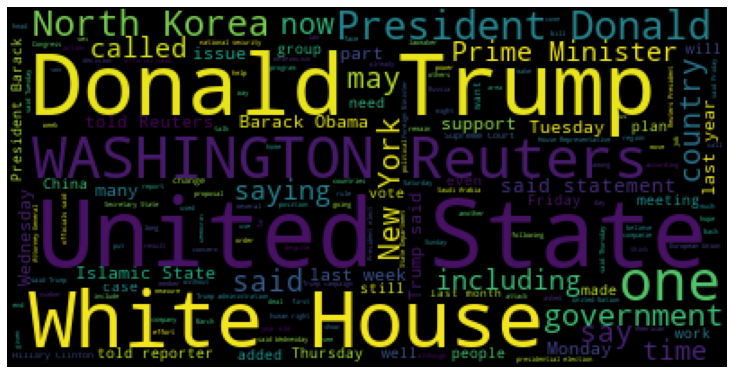

In [17]:
plt.figure(figsize=(10,8))
plt.imshow(wordcloud.generate(real_text))
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()

#Text Pre-Processing

In [18]:
import re
import nltk
from nltk.corpus import stopwords
import string

In [19]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [20]:
ps = nltk.PorterStemmer()

In [21]:
fake = fake.drop(['title','subject','date'], axis=1)
real = real.drop(['title','subject','date'], axis=1)

In [22]:
dataset = fake.append(real, ignore_index=True)

In [23]:
dataset['length']= dataset['text'].apply(len)
dataset.describe()

,class,length
count,44898.000000,44898.000000
mean,0.477015,2469.109693
std,0.499477,2171.617091
min,0.000000,1.000000
25%,0.000000,1234.000000
50%,0.000000,2186.000000
75%,1.000000,3105.000000
max,1.000000,51794.000000


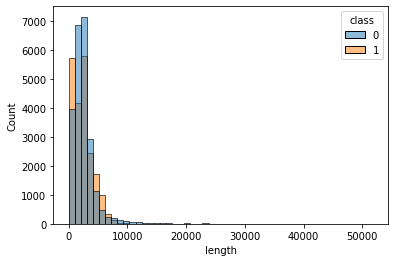

In [24]:
sns.histplot(x='length',data=dataset,bins=50,hue='class')

In [25]:
dataset.drop(index = dataset[dataset['length']>8000].index,axis=0,inplace=True)

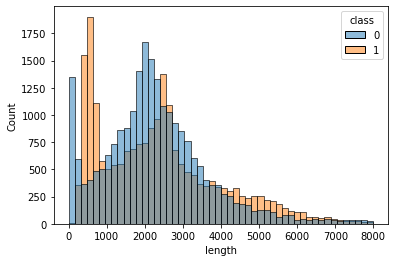

In [26]:
sns.histplot(x='length',data=dataset,bins=50,hue='class')

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f39ccacc4d0>,
      dtype=object)

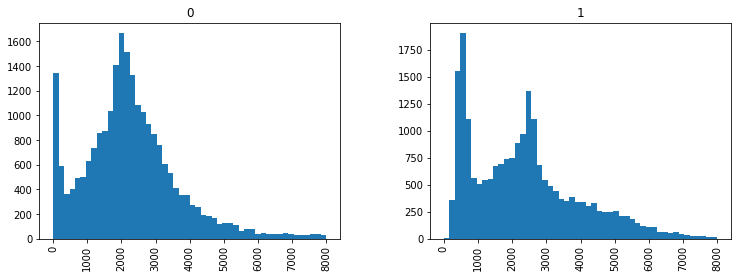

In [27]:
dataset.hist(column='length', by='class', bins=50,figsize=(12,4))

In [71]:
def process_text(sentence):
  sentc = ''.join(re.sub('[^A-Za-z0-9]+',' ',sentence))
  return [ps.stem(word.lower()) for word in sentc.split() if word.lower() not in stopwords.words('english')]


In [72]:
mess = 'i am loving $ % ^ & # @ ! *the NEW WAY9 89T ) of (working'
print(process_text(mess))

['love', '^', 'new', 'way9', '89t', 'work']


In [30]:
dataset['clean_text'] = dataset['text'].apply(lambda x: process_text(x))

In [32]:
dataset['clean_text'].head()

0    [donald, trump, wish, american, happi, new, ye...
1    [hous, intellig, committe, chairman, devin, nu...
2    [friday, reveal, former, milwauke, sheriff, da...
3    [christma, day, donald, trump, announc, would,...
4    [pope, franci, use, annual, christma, day, mes...
Name: clean_text, dtype: object

In [35]:
from keras.models import sequential
from keras.layers import embeddings, LSTM, Dense
from keras.preprocessing.sequence import pad_sequences
from keras.preprocessing.text import one_hot, Tokenizer
from sklearn.model_selection import train_test_split

In [31]:
vocab_size = 20000
embedding_dim = 300
max_length = 8000
trunc_type = 'post'
padding_type = 'post'
oov_tok = "<OOV>"
training_size = 0.8 * (len(dataset))

In [36]:
X_train, X_test, y_train, y_test = train_test_split(dataset['clean_text'], dataset['class'], test_size=0.25, random_state=42,shuffle=True)

In [46]:
print(X_train.head(1))

43368    [reykjavik, reuter, iceland, prime, minist, sa...
Name: clean_text, dtype: object


In [38]:
y_train.shape

(33182,)

In [41]:
tokenizer = Tokenizer(num_words=vocab_size,oov_token=oov_tok)

In [42]:
tokenizer.fit_on_texts(X_train)

In [47]:
word_index = tokenizer.word_index

In [53]:
X_train = tokenizer.texts_to_sequences(X_train)
X_train_padded = pad_sequences(X_train,maxlen=max_length,padding=padding_type,truncating=trunc_type)

X_test = tokenizer.texts_to_sequences(X_test)
X_test_padded = pad_sequences(X_test,maxlen=max_length,padding=padding_type,truncating=trunc_type)

AttributeError: ignored